## Ejercicio 1: Preparación de ambiente de trabajo
- Importe los módulos básicos para el análisis de datos.
- Importe las clases LabelEncoder , StandardScaler y LabelBinarizer de preprocessing
- Importe las funciones train_test_split y cross_val_score de model_selection
- Importe la función classification_report de metrics
- Importe las clases LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis .
- Agregue la base de datos en el ambiente de trabajo.
- Inspeccione la distribución de cada atributo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import lec4_graphs as gfx


In [2]:
df = pd.read_csv('default_credit.csv').drop(columns='index')

In [3]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


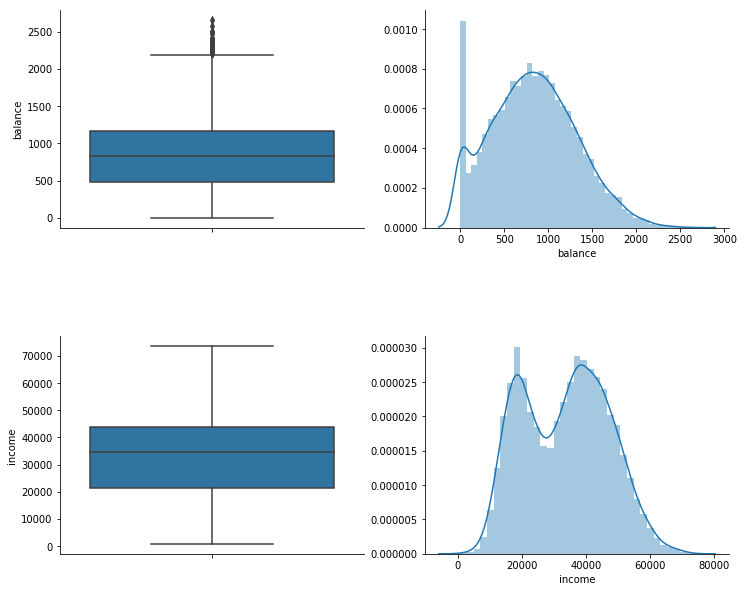

In [4]:
fig, ax=plt.subplots(2,2, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
sns.despine()
for i, col in enumerate(df[["balance","income"]]):
    sns.boxplot(df[col], orient="v",ax=ax[i][0])
    sns.distplot(df[col],ax = ax[i][1])

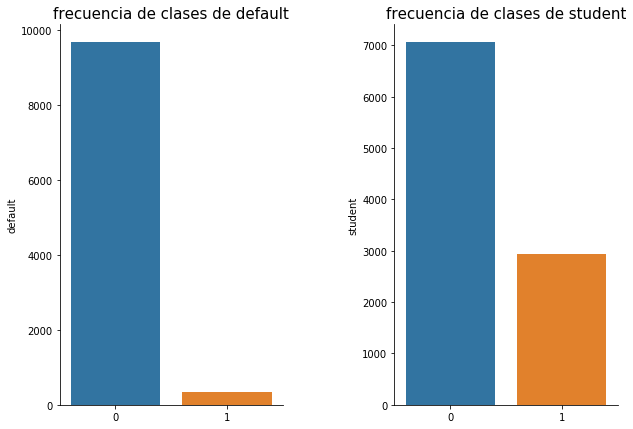

In [20]:
fig, ax=plt.subplots(1,2, figsize=(10,7))
plt.subplots_adjust(wspace=.5)
sns.despine()
for i, col in enumerate(df[["default","student"]]):
   ax[i].set_title("frecuencia de clases de {0}".format(col),size=15)
   sns.barplot(df[col].unique(),df[col].value_counts(), orient="v",ax=ax[i])
    
# hay un desbalance entre las frecuencias de las clases

## Ejercicio 2: Modelo base
- Recuerde que los modelos de sklearn no soportan datos que no sean numéricos. Transforme los atributos pertinentes con LabelEncoder .
- Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
- Genere un modelo con LinearDiscriminantAnalysis sin modificar los hiperparámetros.
- Genere métricas de evaluación utilizando classification_report .
- Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

In [6]:
df['default'] = LabelEncoder().fit_transform(df['default'])
df['student'] = LabelEncoder().fit_transform(df['student'])

In [7]:
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [8]:
X_train_mat, X_test_mat, y_train_vec, y_test_vec = train_test_split(df.loc[:,'student':'income'],
                                                                   df['default'],
                                                                   test_size=.33,
                                                                   random_state=11238)

In [9]:
lda_first =LinearDiscriminantAnalysis().fit(X_train_mat, y_train_vec)

yhat_first = lda_first.predict(X_test_mat)
print(classification_report(y_test_vec, yhat_first))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3186
           1       0.72      0.25      0.38       114

   micro avg       0.97      0.97      0.97      3300
   macro avg       0.85      0.63      0.68      3300
weighted avg       0.97      0.97      0.96      3300



In [10]:
# el desempeño para la clase 0 es bueno, pero para la clase 1 es recall es muy bajo

## Ejercicio 3: Refactorización 1 - información a priori
- Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distribuciones:
    - Asumamos que hay un 50/50 de morosos y no morosos.
    - Asumamos que hay un 60/40 de morosos y no morosos.
    - Por cada modelo, reporte las métricas de clasificación.

In [11]:
priori1=[0.5,0.5]
priori2=[0.6,0.4]


In [12]:
# probamos con priori1
target_label = df['default'].unique()

lda_first_priori1 =LinearDiscriminantAnalysis(priors=[0.5,0.5]).fit(X_train_mat, y_train_vec)

yhat_first_priori1 = lda_first_priori1.predict(X_test_mat)
print(classification_report(y_test_vec, yhat_first_priori1))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3186
           1       0.17      0.92      0.29       114

   micro avg       0.84      0.84      0.84      3300
   macro avg       0.58      0.88      0.60      3300
weighted avg       0.97      0.84      0.89      3300



In [13]:
# probamos con priori1
lda_first_priori2 =LinearDiscriminantAnalysis(priors=[0.6,0.4]).fit(X_train_mat, y_train_vec)

yhat_first_priori2 = lda_first_priori2.predict(X_test_mat)
print(classification_report(y_test_vec, yhat_first_priori2))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      3186
           1       0.21      0.88      0.34       114

   micro avg       0.88      0.88      0.88      3300
   macro avg       0.60      0.88      0.64      3300
weighted avg       0.97      0.88      0.92      3300



## Ejercicio 4: Refactorización 2 - oversampling

Digresión: Synthetic Over(Under)Sampling
Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la
ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de
los conjuntos de entrenamiento. Estos métodos clásicos se conocen como Oversampling
cuando repetimos registros aleatorios de la clase minoritaria, y Undersampling cuando
eliminamos aleatoriamente registros de la clase mayoritaria.
Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada
que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos
replicando estas fallas.
Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento
de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente
forma: En función a un subconjunto de datos correspondientes a la case minoritaria,
entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o
KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio
de atributos de la clase específica mediante $\mathbf{x}{\textsf{nuevo-ejemplo}} =
\mathbf{x}{i} + \lambda (\mathbf{x}{zi} - \mathbf{x}{i})$ donde $\mathbf{x}_{zi}$ es un
ejemplo de entrenamiento de la clase minoritaria y $\lambda$ es un parámetro de
interpolación aleatorio $\lambda \sim \textsf{Uniforme}(0, 1)$.

Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases.
Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic Minority
Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En
nuestro terminal agregamos conda install -c conda-forge imbalanced-learn . Incorpore
SMOTE en el ambiente de trabajo con la siguiente sintáxis from imblearn.over_sampling
import SMOTE .
Para implementar oversampling, debemos generar nuevos objetos que representan nuestra
muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente
sintáxis:

In [14]:
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, ratio='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train_mat, y_train_vec)

In [23]:
lda_first_over =LinearDiscriminantAnalysis().fit(X_train_oversamp, y_train_oversamp)

yhat_first_over = lda_first_over.predict(X_test_mat)
print(classification_report(y_test_vec, yhat_first_over))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3186
           1       0.17      0.92      0.29       114

   micro avg       0.84      0.84      0.84      3300
   macro avg       0.58      0.88      0.60      3300
weighted avg       0.97      0.84      0.89      3300



In [16]:
# interpretar con respecto a precisiion y recall, lectura de clasificacion

## Ejercicio 5: Refactorización 3 - QDA
- Por último, implemente un modelo QuadraticDiscriminantAnalysis con los datos aumentados artificialmente. Genere las métricas de desempeño.
- Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [24]:
qda_model = QuadraticDiscriminantAnalysis(priors=[0.5,0.5]).fit(X_train_oversamp, y_train_oversamp)
qda_class_pred = qda_model.predict(X_test_mat)

In [25]:
print(classification_report(y_test_vec, qda_class_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      3186
           1       0.20      0.89      0.32       114

   micro avg       0.87      0.87      0.87      3300
   macro avg       0.60      0.88      0.63      3300
weighted avg       0.97      0.87      0.91      3300



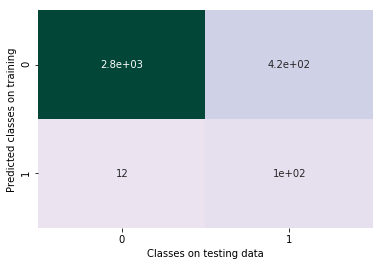

In [28]:
gfx.plot_confusion_matrix(y_test_vec, qda_class_pred,
classes_labels=target_label)

In [26]:
qda_model2 = QuadraticDiscriminantAnalysis(priors=[0.6,0.4]).fit(X_train_oversamp, y_train_oversamp)
qda_class_pred2 = qda_model2.predict(X_test_mat)

In [27]:
print(classification_report(y_test_vec, qda_class_pred2))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3186
           1       0.23      0.87      0.36       114

   micro avg       0.89      0.89      0.89      3300
   macro avg       0.61      0.88      0.65      3300
weighted avg       0.97      0.89      0.92      3300



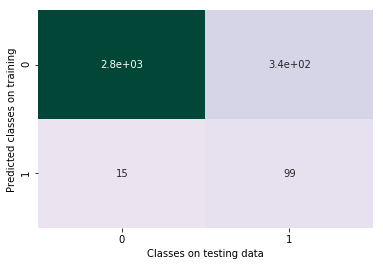

In [29]:
gfx.plot_confusion_matrix(y_test_vec, qda_class_pred2,
classes_labels=target_label)